In [1]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

**Dataset Hand**

In [2]:
objek = 'hand'

In [3]:
def prepare_data(file_name):
    df = pd.read_csv(r'{}'.format(file_name), names=["path", "target"])
    print(df["path"].head())
    np.where(df.applymap(lambda x: x == ''))
    
    # X Input Data
    image_list = []

    for path in df['path'] :
#         print(path) 
        image_arr = cv2.imread(path)
        image_224x224 = cv2.resize(image_arr, (150, 150))
        image_list.append(image_224x224.astype('float')) 
    X = np.array(image_list)
    print("Total Data = ", X.shape)

    # Y Output Data
    encoder = LabelEncoder()
    Targets = encoder.fit_transform(df['target'])
    n_classes = 2
    Y = to_categorical(Targets, num_classes = n_classes)
    
    return X, Y

In [4]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_HAND/patient10169/study1_ne...
1    MURA-v1.1/train/XR_HAND/patient10121/study1_po...
2    MURA-v1.1/train/XR_HAND/patient09111/study1_ne...
3    MURA-v1.1/train/XR_HAND/patient11008/study1_ne...
4    MURA-v1.1/train/XR_HAND/patient09780/study1_po...
Name: path, dtype: object
Total Data =  (5543, 150, 150, 3)
Data Train (4711, 150, 150, 3)
Data Val (832, 150, 150, 3)


In [9]:
Y_train.shape
Y_val.shape

(4711, 2)

(832, 2)

In [3]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import tensorflow as tf 
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = Adamax(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [13]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
19/19 [==============================] - 107s 6s/step - loss: 0.6729 - acc: 0.6848 - val_loss: 0.5703 - val_acc: 0.7512
Epoch 2/20
19/19 [==============================] - 102s 5s/step - loss: 0.5608 - acc: 0.7444 - val_loss: 0.5650 - val_acc: 0.7464
Epoch 3/20
19/19 [==============================] - 115s 6s/step - loss: 0.5341 - acc: 0.7531 - val_loss: 0.5584 - val_acc: 0.7548
Epoch 4/20
19/19 [==============================] - 104s 6s/step - loss: 0.5149 - acc: 0.7610 - val_loss: 0.5554 - val_acc: 0.7512
Epoch 5/20
19/19 [==============================] - 100s 5s/step - loss: 0.4973 - acc: 0.7722 - val_loss: 0.5552 - val_acc: 0.7560
Epoch 6/20
19/19 [==============================] - 97s 5s/step - loss: 0.4810 - acc: 0.7782 - val_loss: 0.5505 - val_acc: 0.7560
Epoch 7/20
19/19 [==============================] - 101s 5s/step - loss: 0.4647 - acc: 0.7928 - val_loss: 0.5473 - val_acc: 0.7608
Epoch 8/20
19/19 [==============================] - 107s 6s/step - loss: 0.4512 - ac

In [5]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_HAND/patient11497/study1_po...
1    MURA-v1.1/valid/XR_HAND/patient11497/study1_po...
2    MURA-v1.1/valid/XR_HAND/patient11497/study1_po...
3    MURA-v1.1/valid/XR_HAND/patient11498/study1_po...
4    MURA-v1.1/valid/XR_HAND/patient11498/study1_po...
Name: path, dtype: object
Total Data =  (460, 150, 150, 3)


In [7]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  58.91 %


In [8]:
Y_pred = model.predict(X_test/255)

15/15 [==============================] - 9s 526ms/step


In [17]:
X_test.shape

(460, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x2166f7d0a30>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

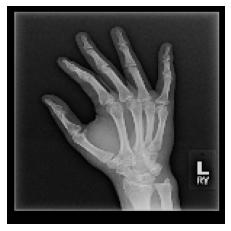

In [9]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

**Dataset Humerus**

In [19]:
objek = 'humerus'

In [20]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_HUMERUS/patient02717/study1...
1    MURA-v1.1/train/XR_HUMERUS/patient02922/study1...
2    MURA-v1.1/train/XR_HUMERUS/patient02746/study1...
3    MURA-v1.1/train/XR_HUMERUS/patient02917/study1...
4    MURA-v1.1/train/XR_HUMERUS/patient02739/study1...
Name: path, dtype: object
Total Data =  (1272, 150, 150, 3)
Data Train (1081, 150, 150, 3)
Data Val (191, 150, 150, 3)


In [21]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
5/5 [==============================] - 23s 5s/step - loss: 0.9639 - acc: 0.5412 - val_loss: 0.9275 - val_acc: 0.4869
Epoch 2/20
5/5 [==============================] - 26s 5s/step - loss: 0.8627 - acc: 0.5393 - val_loss: 0.7425 - val_acc: 0.5812
Epoch 3/20
5/5 [==============================] - 24s 5s/step - loss: 0.6983 - acc: 0.6355 - val_loss: 0.6962 - val_acc: 0.6283
Epoch 4/20
5/5 [==============================] - 28s 6s/step - loss: 0.5988 - acc: 0.6901 - val_loss: 0.6332 - val_acc: 0.6649
Epoch 5/20
5/5 [==============================] - 24s 5s/step - loss: 0.5766 - acc: 0.7040 - val_loss: 0.6010 - val_acc: 0.7225
Epoch 6/20
5/5 [==============================] - 22s 5s/step - loss: 0.5304 - acc: 0.7484 - val_loss: 0.6022 - val_acc: 0.6963
Epoch 7/20
5/5 [==============================] - 26s 5s/step - loss: 0.4996 - acc: 0.7780 - val_loss: 0.5863 - val_acc: 0.7277
Epoch 8/20
5/5 [==============================] - 22s 5s/step - loss: 0.4860 - acc: 0.7983 - val_loss: 0

In [23]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_HUMERUS/patient11608/study1...
1    MURA-v1.1/valid/XR_HUMERUS/patient11608/study1...
2    MURA-v1.1/valid/XR_HUMERUS/patient11214/study1...
3    MURA-v1.1/valid/XR_HUMERUS/patient11214/study1...
4    MURA-v1.1/valid/XR_HUMERUS/patient11609/study1...
Name: path, dtype: object
Total Data =  (288, 150, 150, 3)


In [24]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  50.0 %


In [25]:
Y_pred = model_load.predict(X_test/255)

9/9 [==============================] - 7s 589ms/step


In [26]:
X_test.shape

(288, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x1a18eb79a50>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

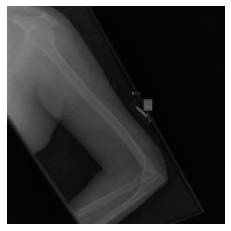

In [27]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

**Shoulder Dataset**

In [2]:
objek = 'shoulder'

In [5]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_SHOULDER/patient01685/study...
1    MURA-v1.1/train/XR_SHOULDER/patient02206/study...
2    MURA-v1.1/train/XR_SHOULDER/patient01976/study...
3    MURA-v1.1/train/XR_SHOULDER/patient01071/study...
4    MURA-v1.1/train/XR_SHOULDER/patient02526/study...
Name: path, dtype: object
Total Data =  (8364, 150, 150, 3)
Data Train (7109, 150, 150, 3)
Data Val (1255, 150, 150, 3)


In [8]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
28/28 [==============================] - 165s 5s/step - loss: 0.9739 - acc: 0.5866 - val_loss: 0.6406 - val_acc: 0.6542
Epoch 2/20
28/28 [==============================] - 151s 5s/step - loss: 0.6074 - acc: 0.6901 - val_loss: 0.6229 - val_acc: 0.6725
Epoch 3/20
28/28 [==============================] - 146s 5s/step - loss: 0.5714 - acc: 0.7216 - val_loss: 0.6189 - val_acc: 0.6717
Epoch 4/20
28/28 [==============================] - 148s 5s/step - loss: 0.5516 - acc: 0.7275 - val_loss: 0.6310 - val_acc: 0.6677
Epoch 5/20
28/28 [==============================] - 166s 6s/step - loss: 0.5257 - acc: 0.7564 - val_loss: 0.6156 - val_acc: 0.6805
Epoch 6/20
28/28 [==============================] - 158s 6s/step - loss: 0.5030 - acc: 0.7721 - val_loss: 0.6049 - val_acc: 0.6845
Epoch 7/20
28/28 [==============================] - 152s 5s/step - loss: 0.4828 - acc: 0.7873 - val_loss: 0.6018 - val_acc: 0.6789
Epoch 8/20
28/28 [==============================] - 155s 6s/step - loss: 0.4632 - a

In [10]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_SHOULDER/patient11676/study...
1    MURA-v1.1/valid/XR_SHOULDER/patient11676/study...
2    MURA-v1.1/valid/XR_SHOULDER/patient11676/study...
3    MURA-v1.1/valid/XR_SHOULDER/patient11703/study...
4    MURA-v1.1/valid/XR_SHOULDER/patient11703/study...
Name: path, dtype: object
Total Data =  (563, 150, 150, 3)


In [11]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  50.44 %


In [12]:
Y_pred = model_load.predict(X_test/255)

18/18 [==============================] - 11s 539ms/step


In [13]:
X_test.shape

(563, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x1e55c1ea320>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

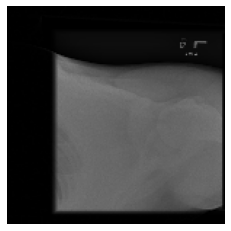

In [14]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

**Wrist Dataset**

In [5]:
objek = 'wrist'

In [5]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_WRIST/patient07688/study1_n...
1    MURA-v1.1/train/XR_WRIST/patient06904/study1_p...
2    MURA-v1.1/train/XR_WRIST/patient06806/study1_p...
3    MURA-v1.1/train/XR_WRIST/patient06442/study1_p...
4    MURA-v1.1/train/XR_WRIST/patient00305/study1_n...
Name: path, dtype: object
Total Data =  (9739, 150, 150, 3)
Data Train (8278, 150, 150, 3)
Data Val (1461, 150, 150, 3)


In [6]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
33/33 [==============================] - 187s 5s/step - loss: 1.0561 - acc: 0.6187 - val_loss: 0.6117 - val_acc: 0.6790
Epoch 2/20
33/33 [==============================] - 175s 5s/step - loss: 0.5593 - acc: 0.7341 - val_loss: 0.5474 - val_acc: 0.7180
Epoch 3/20
33/33 [==============================] - 170s 5s/step - loss: 0.5187 - acc: 0.7569 - val_loss: 0.5321 - val_acc: 0.7379
Epoch 4/20
33/33 [==============================] - 164s 5s/step - loss: 0.4926 - acc: 0.7722 - val_loss: 0.5216 - val_acc: 0.7495
Epoch 5/20
33/33 [==============================] - 160s 5s/step - loss: 0.4717 - acc: 0.7861 - val_loss: 0.5184 - val_acc: 0.7515
Epoch 6/20
33/33 [==============================] - 171s 5s/step - loss: 0.4539 - acc: 0.7971 - val_loss: 0.5082 - val_acc: 0.7645
Epoch 7/20
33/33 [==============================] - 169s 5s/step - loss: 0.4392 - acc: 0.8074 - val_loss: 0.5052 - val_acc: 0.7714
Epoch 8/20
33/33 [==============================] - 167s 5s/step - loss: 0.4249 - a

In [6]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1    MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2    MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3    MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4    MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
Name: path, dtype: object
Total Data =  (659, 150, 150, 3)


In [7]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))

In [8]:
score = model_load.evaluate(X_test, Y_test, verbose=0)

In [9]:
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  55.24 %


In [10]:
Y_pred = model_load.predict(X_test/255)

21/21 [==============================] - 13s 580ms/step


In [11]:
X_test.shape

(659, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x11714aab640>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

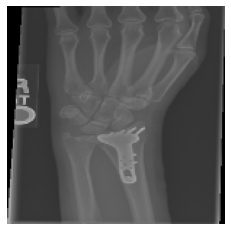

In [12]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')


**Dataset Elbow**

In [13]:
objek = 'elbow'

In [14]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_ELBOW/patient05456/study1_p...
1    MURA-v1.1/train/XR_ELBOW/patient04779/study1_p...
2    MURA-v1.1/train/XR_ELBOW/patient00222/study1_n...
3    MURA-v1.1/train/XR_ELBOW/patient05301/study1_p...
4    MURA-v1.1/train/XR_ELBOW/patient03193/study1_n...
Name: path, dtype: object
Total Data =  (4931, 150, 150, 3)
Data Train (4191, 150, 150, 3)
Data Val (740, 150, 150, 3)


In [15]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
17/17 [==============================] - 111s 5s/step - loss: 1.3496 - acc: 0.5326 - val_loss: 0.7506 - val_acc: 0.6216
Epoch 2/20
17/17 [==============================] - 89s 5s/step - loss: 0.6549 - acc: 0.6731 - val_loss: 0.5957 - val_acc: 0.7270
Epoch 3/20
17/17 [==============================] - 90s 5s/step - loss: 0.5780 - acc: 0.7268 - val_loss: 0.5713 - val_acc: 0.7486
Epoch 4/20
17/17 [==============================] - 90s 5s/step - loss: 0.5482 - acc: 0.7483 - val_loss: 0.5532 - val_acc: 0.7608
Epoch 5/20
17/17 [==============================] - 85s 5s/step - loss: 0.5181 - acc: 0.7619 - val_loss: 0.5419 - val_acc: 0.7595
Epoch 6/20
17/17 [==============================] - 88s 5s/step - loss: 0.4954 - acc: 0.7814 - val_loss: 0.5353 - val_acc: 0.7743
Epoch 7/20
17/17 [==============================] - 89s 5s/step - loss: 0.4757 - acc: 0.7922 - val_loss: 0.5287 - val_acc: 0.7838
Epoch 8/20
17/17 [==============================] - 89s 5s/step - loss: 0.4631 - acc: 0.8

In [16]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...
1    MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...
2    MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...
3    MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...
4    MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...
Name: path, dtype: object
Total Data =  (465, 150, 150, 3)


In [17]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  53.33 %


In [18]:
Y_pred = model_load.predict(X_test/255)

15/15 [==============================] - 10s 591ms/step


In [19]:
X_test.shape

(465, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x11713b8f670>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

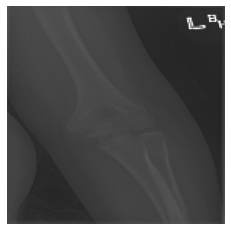

In [20]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

**Finger Dataset**

In [21]:
objek = 'finger'

In [22]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_FINGER/patient03402/study1_...
1    MURA-v1.1/train/XR_FINGER/patient04428/study1_...
2    MURA-v1.1/train/XR_FINGER/patient03833/study1_...
3    MURA-v1.1/train/XR_FINGER/patient04139/study1_...
4    MURA-v1.1/train/XR_FINGER/patient02922/study1_...
Name: path, dtype: object
Total Data =  (5106, 150, 150, 3)
Data Train (4340, 150, 150, 3)
Data Val (766, 150, 150, 3)


In [23]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
17/17 [==============================] - 99s 6s/step - loss: 0.6752 - acc: 0.6431 - val_loss: 0.6115 - val_acc: 0.6749
Epoch 2/20
17/17 [==============================] - 93s 6s/step - loss: 0.5737 - acc: 0.7058 - val_loss: 0.5811 - val_acc: 0.6854
Epoch 3/20
17/17 [==============================] - 90s 5s/step - loss: 0.5339 - acc: 0.7302 - val_loss: 0.5725 - val_acc: 0.6815
Epoch 4/20
17/17 [==============================] - 93s 6s/step - loss: 0.5042 - acc: 0.7553 - val_loss: 0.5656 - val_acc: 0.6919
Epoch 5/20
17/17 [==============================] - 89s 5s/step - loss: 0.4804 - acc: 0.7684 - val_loss: 0.5637 - val_acc: 0.6854
Epoch 6/20
17/17 [==============================] - 94s 6s/step - loss: 0.4619 - acc: 0.7841 - val_loss: 0.5623 - val_acc: 0.6984
Epoch 7/20
17/17 [==============================] - 96s 6s/step - loss: 0.4430 - acc: 0.7993 - val_loss: 0.5584 - val_acc: 0.6971
Epoch 8/20
17/17 [==============================] - 95s 6s/step - loss: 0.4286 - acc: 0.81

In [24]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_FINGER/patient11882/study1_...
1    MURA-v1.1/valid/XR_FINGER/patient11882/study1_...
2    MURA-v1.1/valid/XR_FINGER/patient11883/study1_...
3    MURA-v1.1/valid/XR_FINGER/patient11883/study1_...
4    MURA-v1.1/valid/XR_FINGER/patient11883/study1_...
Name: path, dtype: object
Total Data =  (461, 150, 150, 3)


In [25]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  46.42 %


In [26]:
Y_pred = model_load.predict(X_test/255)

15/15 [==============================] - 10s 597ms/step


In [27]:
X_test.shape

(461, 150, 150, 3)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x11735956ad0>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

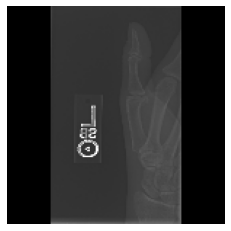

In [28]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

**Forearm Dataset**

In [4]:
objek = 'forearm'

In [30]:
X, Y = prepare_data("{}_with_label_randomized.csv".format(objek))
X = X/255
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13)
print("Data Train", X_train.shape)
print("Data Val", X_val.shape)

0    MURA-v1.1/train/XR_FOREARM/patient09614/study1...
1    MURA-v1.1/train/XR_FOREARM/patient09541/study1...
2    MURA-v1.1/train/XR_FOREARM/patient01951/study1...
3    MURA-v1.1/train/XR_FOREARM/patient09113/study1...
4    MURA-v1.1/train/XR_FOREARM/patient09552/study1...
Name: path, dtype: object
Total Data =  (1825, 150, 150, 3)
Data Train (1551, 150, 150, 3)
Data Val (274, 150, 150, 3)


In [31]:
save_at = "Inception_Model/inception_{}.h5".format(objek)
save_best = ModelCheckpoint (save_at, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
hist = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), callbacks=[save_best], batch_size=256, epochs = 20)

Epoch 1/20
7/7 [==============================] - 35s 5s/step - loss: 0.6204 - acc: 0.6957 - val_loss: 0.6203 - val_acc: 0.7044
Epoch 2/20
7/7 [==============================] - 35s 5s/step - loss: 0.5433 - acc: 0.7466 - val_loss: 0.5579 - val_acc: 0.7518
Epoch 3/20
7/7 [==============================] - 32s 5s/step - loss: 0.4950 - acc: 0.7737 - val_loss: 0.6047 - val_acc: 0.7336
Epoch 4/20
7/7 [==============================] - 36s 5s/step - loss: 0.4578 - acc: 0.8053 - val_loss: 0.5313 - val_acc: 0.7664
Epoch 5/20
7/7 [==============================] - 32s 5s/step - loss: 0.4307 - acc: 0.8227 - val_loss: 0.5484 - val_acc: 0.7518
Epoch 6/20
7/7 [==============================] - 34s 5s/step - loss: 0.3906 - acc: 0.8440 - val_loss: 0.5041 - val_acc: 0.7810
Epoch 7/20
7/7 [==============================] - 32s 5s/step - loss: 0.3738 - acc: 0.8511 - val_loss: 0.5080 - val_acc: 0.7774
Epoch 8/20
7/7 [==============================] - 32s 5s/step - loss: 0.3553 - acc: 0.8678 - val_loss: 0

In [5]:
X_test, Y_test = prepare_data("{}_val_path_label.csv".format(objek))

0    MURA-v1.1/valid/XR_FOREARM/patient11392/study1...
1    MURA-v1.1/valid/XR_FOREARM/patient11392/study1...
2    MURA-v1.1/valid/XR_FOREARM/patient11392/study1...
3    MURA-v1.1/valid/XR_FOREARM/patient11393/study1...
4    MURA-v1.1/valid/XR_FOREARM/patient11393/study1...
Name: path, dtype: object
Total Data =  (301, 150, 150, 3)


In [6]:
model_load = load_model("Inception_Model/inception_{}.h5".format(objek))
score = model_load.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  49.83 %


In [7]:
Y_pred = model_load.predict(X_test/255)

10/10 [==============================] - 6s 492ms/step


In [ ]:
X_test.shape

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x25121fd72b0>, (-0.5, 149.5, 149.5, -0.5))

NameError: name 'encoder' is not defined

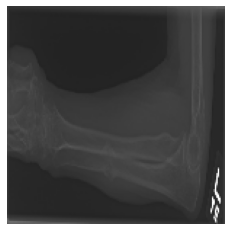

In [8]:
np.random.seed(89)
for rand_num in np.random.randint(0, len(Y_test), 15):
  plt.figure()
  plt.imshow(X_test[rand_num].astype('int')), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')